In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg

%matplotlib inline

# undistort
# some threshold (on grayscale and/or color and/or HLS)
# transform
# sliding window
# detect lines
# draw lines over the transformed image
# reverse transform


In [2]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.




def set_obj_and_img_points():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

   

    # Make a list of calibration images
    cal_images = glob.glob('./camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(10)
    cv2.destroyAllWindows()
    
def calibrate_camera( test_image):
    img_size = (test_image.shape[1], test_image.shape[0])

    set_obj_and_img_points()

    if len(objpoints) == 0 or len(imgpoints) == 0:
        raise Exception("Calibration Failed!")

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    return mtx,dist
    
    

    
def abs_sobel_thresh( gray, orient='x', thresh_min=40, thresh_max=200, ksize=5):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)

    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(gray, thresh_min=40, thresh_max=250, ksize=7):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255 

    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)

    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output


def dir_threshold(gray, ksize=7, thresh=(0.7, 1.3)):

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)

    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    binary_output =  np.zeros_like(absgraddir)

    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def gradient_binary( gray, thresh_min=40, thresh_max=250, ksize=7, thresh=(0.7, 1.3)):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x',thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize)

    grady = abs_sobel_thresh(gray, orient='y', thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize)

    mag_binary = mag_thresh(gray, thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize)

    dir_binary = dir_threshold(gray, ksize=ksize, thresh=thresh)

    combined = np.zeros_like(dir_binary)

    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Return the result
    return combined

def binary_transform( img, thresh_min=40, thresh_max=250, ksize=7, thresh=(0.7, 1.3), hls_thresh=(175, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold gradient
    sxbinary = gradient_binary(gray, thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize, thresh=thresh)

    # Threshold color channel
    s_binary = to_hls(img)

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Return the result
    return combined_binary

def to_hls(img, hls_thresh=(50, 200)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    s_channel = hls[:,:,2]

    binary_output = np.zeros_like(s_channel)

    binary_output[(s_channel > hls_thresh[0]) & (s_channel <= hls_thresh[1])] = 1

    return binary_output


def perspective_transform(binary):
    img_size = (binary.shape[1], binary.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    

    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
     # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    return cv2.warpPerspective(binary, M, img_size),src,dst



In [93]:
def detect_lines_first_frame(binary_warped,left_line, right_line):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(int(histogram.shape[0]/2))

    leftx_base = np.argmax(histogram[:midpoint])

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #print('Midpoint',midpoint)
    #print('leftx_base',leftx_base)
    #print('rightx_base',rightx_base)

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height

        win_y_high = binary_warped.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin

        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin

        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image

        cv2.rectangle(out_img, (win_xleft_low, win_y_low),(win_xleft_high, win_y_high), (0, 255, 0), 2) 

        cv2.rectangle(out_img, (win_xright_low, win_y_low),(win_xright_high, win_y_high), (0, 255, 0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)

        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)

    right_lane_inds = np.concatenate(right_lane_inds)


#         print(left_lane_inds, right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]

    lefty = nonzeroy[left_lane_inds] 

    rightx = nonzerox[right_lane_inds]

    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)

    right_fit = np.polyfit(righty, rightx, 2)
    

    #print(len(left_fit), len(right_fit))

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 600 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad*3.28084, 'ft', right_curverad*3.28084, 'ft')
    left_line.detected = True
    right_line.detected = True
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
    print(left_curverad, 'm', right_curverad, 'm')
    
    image_center = int(binary_warped.shape[1]/2)
    # calculate deviation in pixels space:
    off_center_deviation = image_center - (rightx_current + leftx_current) / 2
    # scale the estimation to the world space
    off_center_deviation_meters = off_center_deviation * xm_per_pix
    left_line.line_base_pos = off_center_deviation_meters
    print('offset from center',off_center_deviation_meters)
#         Example values: 632.1 m    626.2 m

#         raise RuntimeError("OK")

    # This is ONLY for plotting
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    return left_fit,right_fit

def fit_line(left_fit,right_fit,binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    return left_fitx,right_fitx,ploty

def fit_poly_line(binary_warped, nonzerox,nonzeroy,left_lane_inds,right_lane_inds):
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]

    lefty = nonzeroy[left_lane_inds] 

    rightx = nonzerox[right_lane_inds]

    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)

    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 600 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad*3.28084, 'ft', right_curverad*3.28084, 'ft')
    #print(left_curverad, 'm', right_curverad, 'm')
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
    
    # Lane position calculation
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    midpoint = np.int(int(histogram.shape[0]/2))
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    image_center = int(binary_warped.shape[1]/2)
    # calculate deviation in pixels space:
    off_center_deviation = image_center - (rightx_base + leftx_base) / 2
    # scale the estimation to the world space
    off_center_deviation_meters = off_center_deviation * xm_per_pix
    left_line.line_base_pos = off_center_deviation_meters
    
    return left_fit,right_fit , left_curverad, right_curverad
    

In [94]:
def detect_lines_from_previous( binary_warped, orig, left_line, right_line):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_line.inds = ((nonzerox >
                       (left_line.current_fit[0] * (nonzeroy**2)
                        + left_line.current_fit[1] * nonzeroy
                        + left_line.current_fit[2] - margin))
                      & (nonzerox < (left_line.current_fit[0] * (nonzeroy**2)
                                     + left_line.current_fit[1] * nonzeroy
                                     + left_line.current_fit[2] + margin)))

    right_line.inds = ((nonzerox > (right_line.current_fit[0] * (nonzeroy**2)
                                    + right_line.current_fit[1] * nonzeroy
                                    + right_line.current_fit[2] - margin))
                       & (nonzerox < (right_line.current_fit[0] * (nonzeroy**2)
                                      + right_line.current_fit[1] * nonzeroy
                                      + right_line.current_fit[2] + margin)))
    
    #self.set_lane_lines(nonzerox, nonzeroy)
    left_fit,right_fit , left_curverad, right_curverad = fit_poly_line(binary_warped, 
                                                                       nonzerox,nonzeroy,
                                                                       left_line.inds,
                                                                       right_line.inds)
    
    left_fitx,right_fitx,ploty = fit_line(left_fit,right_fit,binary_warped)
    
    left_line.detected = True
    right_line.detected = True
    #self.sanity_check(binary_warped, orig, prev=True)

    #return self.project_lane(binary_warped, orig, nonzeroy, nonzerox)
    
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
    #print(left_curverad, right_curverad)
    return left_fit,right_fit

In [95]:
def plot_image(binary_warped,left_fitx,right_fitx):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #get inverse M
    Minv = cv2.getPerspectiveTransform( dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result
    #cv2.imshow('img',result)

In [96]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [97]:
def validity_check(left_line, right_line):
    valid = False
    center = True
    if abs(left_line.radius_of_curvature - right_line.radius_of_curvature) > 400:
        parrellel = False
    
   
        


In [29]:
#Clibrate the Camera
images = glob.glob('camera_cal/calibration*.jpg')
test_image = images.pop(-1)
img_t = cv2.imread(test_image)
#plt.imshow(img_t)
mtx, dist = calibrate_camera(img_t)

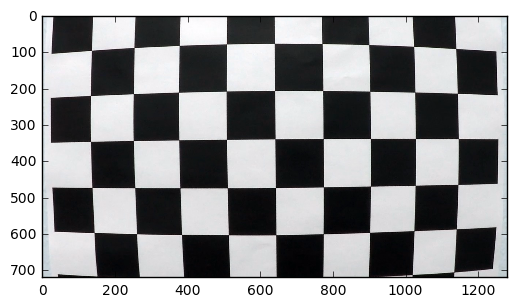

In [30]:
img_t = cv2.imread('camera_cal/calibration1.jpg')
cv2.imwrite('output_images/chessboard_ori.jpg',img_t)
plt.imshow(img_t)

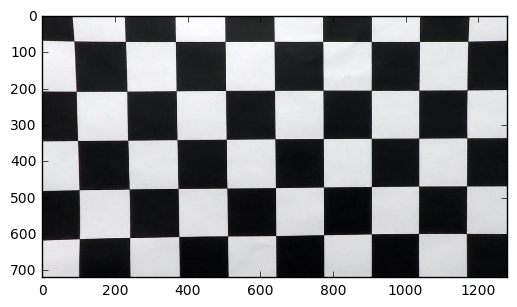

In [33]:

img_t = cv2.imread('camera_cal/calibration1.jpg')
#plt.imshow(img_t)
mtx, dist = calibrate_camera(img_t)
dst = cv2.undistort(img_t, mtx, dist, None, mtx)
cv2.imwrite('output_images/chessboard_undist.jpg',dst)
plt.imshow(dst)

In [34]:
print(mtx)
print(dist)

[[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


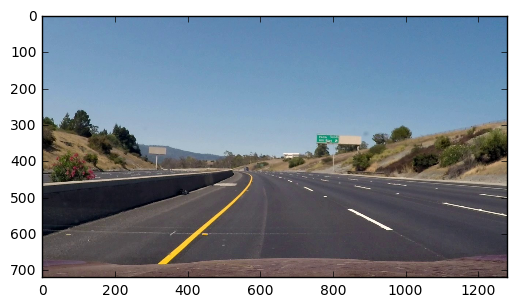

In [99]:
img = mpimg.imread('./project_video_export/frame1.jpg')
cv2.imwrite('output_images/frame1_orig.jpg',img)
plt.imshow(img)

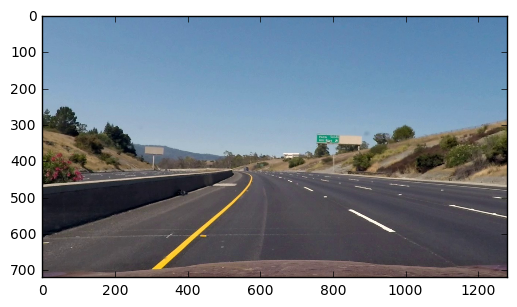

In [100]:
un_deis_img = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/frame1_undist.jpg',un_deis_img)
plt.imshow(un_deis_img)

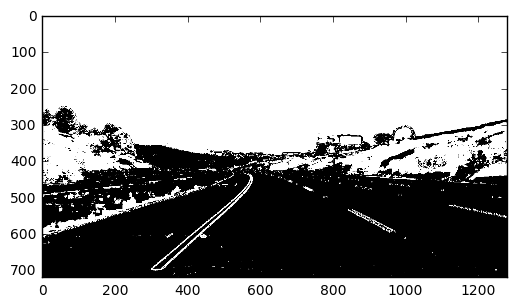

In [101]:
binary = binary_transform(un_deis_img, thresh_min=40, thresh_max=200, ksize=3, thresh=(0.7, 1.3), hls_thresh=(175, 255))
cv2.imwrite('output_images/frame1_processed.jpg',binary)
plt.imshow(binary,  cmap='gray')

[[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


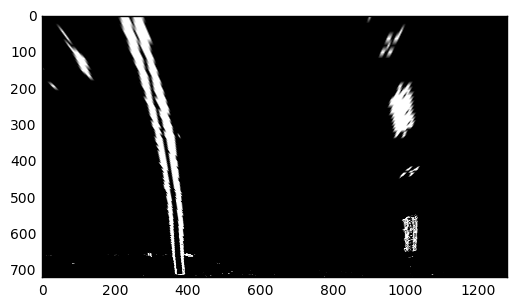

In [102]:
binary_warped,src,dst = perspective_transform(binary)
cv2.imwrite('output_images/binary_warped.jpg',binary_warped)
plt.imshow(binary_warped,  cmap='gray')
print(src)
print(dst)

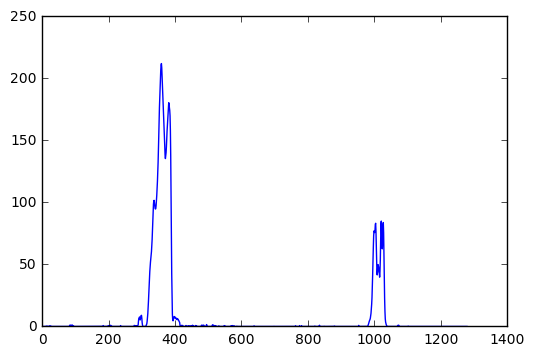

In [103]:
import numpy as np
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [104]:
left_line = Line()
right_line = Line()

538.832166647 m 724.170352255 m
offset from center 0.20966666666666667


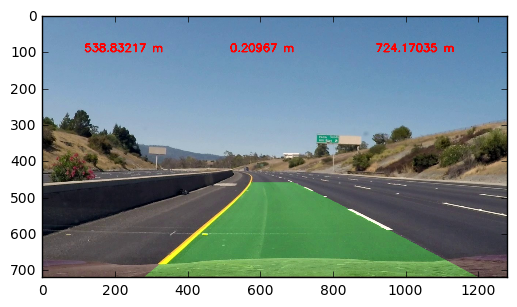

In [105]:


left_line.current_fit, right_line.current_fit = detect_lines_first_frame(binary_warped,left_line,right_line )

#left_line.current_fit, right_line.current_fit = detect_lines_from_previous(binary_warped, img,left_line, right_line)

left_fitx,right_fitx,ploty = fit_line(left_line.current_fit, right_line.current_fit,binary_warped)

#plt.imshow(binary_warped)
out_img = plot_image(binary_warped,left_fitx,right_fitx)
txt = ' '+ str(round(left_line.radius_of_curvature,5)) + ' m'
cv2.putText(out_img,txt, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255,3)
txt = ' '+ str(round(left_line.line_base_pos,5)) + ' m'
cv2.putText(out_img,txt, (500,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255,3)
txt = ' '+ str(round(right_line.radius_of_curvature,5)) + ' m'
cv2.putText(out_img,txt, (900,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255,3)
cv2.imwrite('output_images/frame1_lanes.jpg',out_img)
plt.imshow(out_img)
#plot_image(binary_warped,left_fitx,right_fitx)



In [106]:
def process_image(img, left_line, right_line):
    #count += 1
    #bad_count = 0
    un_deis_img = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_transform(un_deis_img, thresh_min=40, thresh_max=200, ksize=3, thresh=(0.7, 1.3), hls_thresh=(175, 255))

    binary_warped,src,dst = perspective_transform(binary)

   
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[
                        0] - 1, binary_warped.shape[0])

    if left_line.detected and right_line.detected:
        #print('Line has detected before')
        left_fitx,right_fitx = detect_lines_from_previous(binary_warped, img,left_line, right_line)
        return binary_warped,left_fitx,right_fitx
    
    #print('Line has NOT detected before')
    left_fitx,right_fitx = detect_lines_first_frame(binary_warped,left_line, right_line)
    #print(left_line.detected)
    return binary_warped,left_fitx,right_fitx

In [108]:
img = cv2.imread('./project_video_export/frame1.jpg')


#plt.imshow(img)
left_line = Line()
right_line = Line()
image_out_arr = []
vidcap = cv2.VideoCapture('project_video.mp4')
success,img = vidcap.read()
count = 0
success = True
while success:
    print(count)
    success,img = vidcap.read()
    #print ('Read a new frame: ', success , count)
    #cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
    if success == True:
        binary_warped,left_line.current_fit,right_line.current_fit = process_image(img, left_line, right_line)
        left_fitx,right_fitx,ploty = fit_line(left_line.current_fit, right_line.current_fit,binary_warped)
        #plt.imshow(binary_warped)
        
        out_img = plot_image(binary_warped,left_fitx,right_fitx)
        
        out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        txt = ' '+ str(round(left_line.radius_of_curvature,5)) + ' m'
        cv2.putText(out_img,txt, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255,3)
        txt = ' '+ str(round(left_line.line_base_pos,5)) + ' m'
        cv2.putText(out_img,txt, (500,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255,3)
        txt = ' '+ str(round(right_line.radius_of_curvature,5)) + ' m'
        cv2.putText(out_img,txt, (900,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255,3)
        image_out_arr.append(out_img)
        #cv2.imshow('img',out_img)
        #cv2.waitKey(10)
        #if count > 10:
           # break
    
    #cv2.waitKey(10)
    count += 1
   
#cv2.destroyAllWindows()

from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(image_out_arr, fps=24)

clip.write_videofile('video_out_1.mp4', audio=False)



0
536.799154931 m 713.76498997 m
offset from center 0.20966666666666667
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259


100%|██████████████████████████████████████| 1256/1256 [01:11<00:00, 17.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out_1.mp4 

